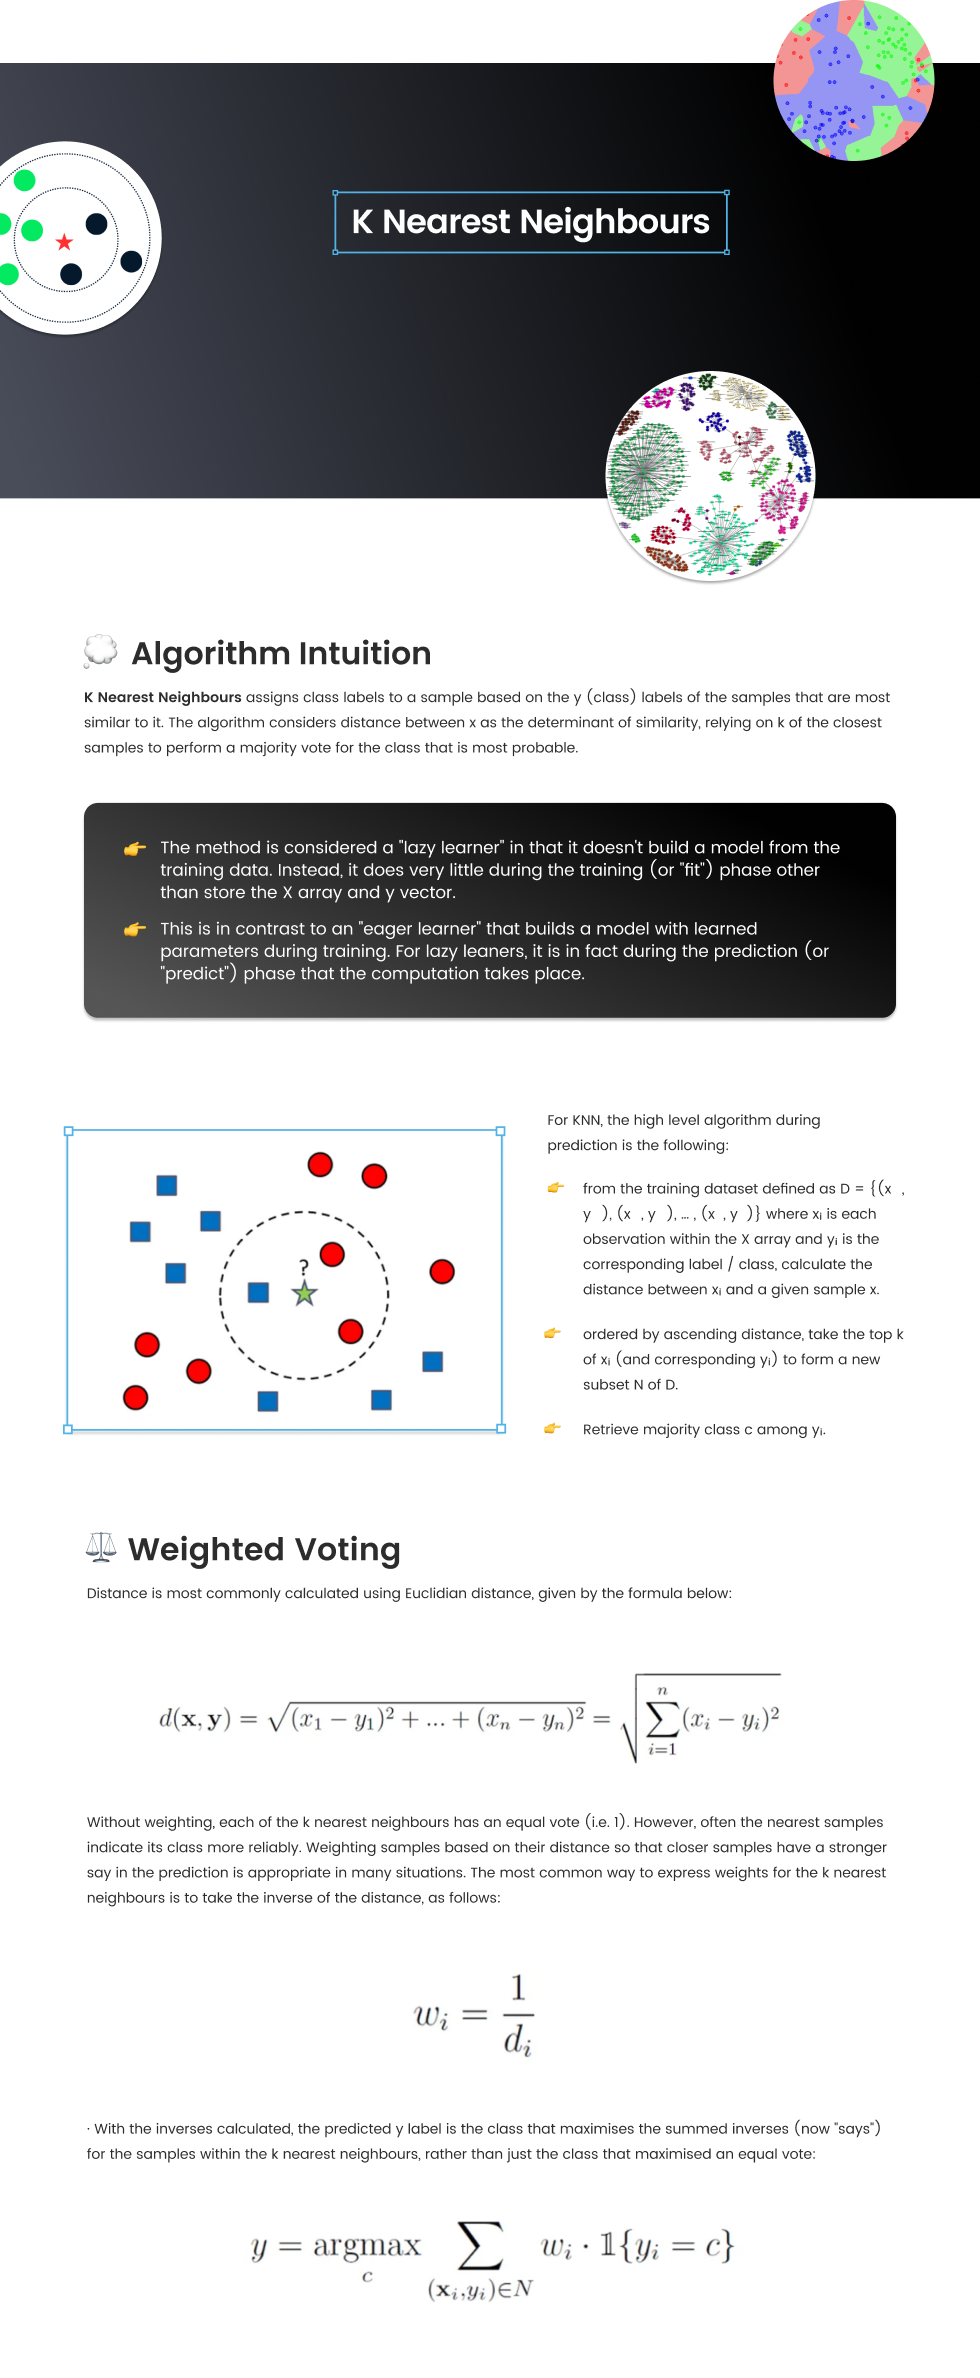

In [249]:
from IPython.display import Image
Image("images\Figma_KNN.png")

*Import Libraries*

In [250]:
# import custom classes, functions and variables. Reload file in to memory on cell excution.
import importlib
import settings
importlib.reload(settings)

# import data frameworks
import pandas as pd
import numpy as np

# import viz
import matplotlib.pyplot as plt
import seaborn as sns

# import ML
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as Pipeline_imb
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
import statsmodels.api as sm
from imblearn.over_sampling import SMOTENC


# import others
import os
import pickle
import warnings

# Specific warning categories to be ignored
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

*Import data from initial EDA*

In [251]:
df = pd.read_csv(os.path.join(settings.DATA_EDA_DIR, settings.DATA_EDA_FILE), sep=",")
if len(df) > 0:
    print("df loaded")

df loaded


*Split data and prepare labels*

In [252]:
ALL_FEATURES = ['Gender', 'Age', 'Occupation', 'Sleep Duration', 'Quality of Sleep', 
                'Physical Activity Level', 'Stress Level', 'BMI Category', 'Heart Rate', 
                'Daily Steps', 'Blood Pressure Category']
X = df[ALL_FEATURES]
y = df[settings.LABEL]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Encode y vector 
map = {"None":0, "Sleep Apnea":1, "Insomnia":2}
# apply mapping function
settings.column_mapper(y_train, "Sleep Disorder", map)
settings.column_mapper(y_test, "Sleep Disorder", map)

# reshape labels to 1-D array (vector) 
y_train, y_test = y_train.values.reshape(-1), y_test.values.reshape(-1)

*Preprocess steps*

In [253]:
# Create a column transformer for ohe and scaling
column_trans = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'), X_train.select_dtypes(include=['object']).columns),
        ('scale', StandardScaler(), X_train.select_dtypes(include=['float64', 'int64']).columns)
    ],
    remainder='passthrough')

transformed_X_train_array = column_trans.fit_transform(X_train)
transformed_X_test_array = column_trans.transform(X_test)

# Convert to df as a sense check. Use only for interpretibility before using for pipeline. 
transformed_X_train_df = settings.convert_transformed_features_to_df(column_trans, transformed_X_train_array)
transformed_X_test_df = settings.convert_transformed_features_to_df(column_trans, transformed_X_test_array)

# # Check ohe and scaled datasets
# display("train: check for dummy encoded columns and scaled values (mean 0 and std 1)",transformed_X_train_df.shape, transformed_X_train_df.describe().loc[["mean", "std"],:])
# display("test: check for same dummy encoded columns and scaled values (mean close to 0 and std close to 1)",transformed_X_test_df.shape, transformed_X_test_df.describe().loc[["mean", "std"],:])

*Create pipeline and base model*

In [254]:
# create model
model_knn = KNeighborsClassifier() # default n_neighbors=5, weights='uniform', algorithm='auto', leaf_size=30, p=2, metric='minkowski'

# create sklearn pipeline
pipeline_knn = settings.create_pipeline(["preprocess", column_trans], ["knn_classifier", model_knn])

# create cross validation object for cross_val_score
cv_knn = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=42)

# define custom scorer for this work: positive label (class 1 and 2) F1 score
base_scorer = settings.CustomPositiveF1Scorer().scorer_function
custom_scorer = settings.CustomPositiveF1Scorer().custom_scorer

# run training cross validation on pipeline 
cv_scores = cross_val_score(pipeline_knn, X_train, y_train, scoring=custom_scorer, cv=cv_knn)

settings.cross_val_summary(pipeline_knn, cv_scores, X_train, y_train, X_test, y_test, scorer=base_scorer)

Train Score: 84.100 %
Mean CV Train Score: 80.7700 % ( +- 6.100 % )
Test Score: 85.100 %



Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98        66
           1       0.81      0.88      0.84        24
           2       0.90      0.83      0.86        23

    accuracy                           0.93       113
   macro avg       0.90      0.90      0.90       113
weighted avg       0.93      0.93      0.93       113



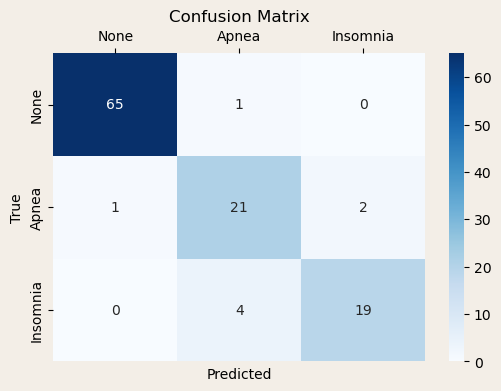

In [255]:
# Generate prediction and show classification report
y_pred = pipeline_knn.predict(X_test)
class_report = classification_report(y_test, y_pred)
print("\nClassification Report:\n", class_report)

# Generate confusion matrix
class_labels = ["None","Apnea","Insomnia"]
conf_matrix = confusion_matrix(y_test, y_pred)

settings.plot_conf_matrix(class_labels, conf_matrix)

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left; max-width: 1050px; margin: 0 auto; color: #444444;">

<h3 align="left"><font color='#DEB887'>💡 Insights:</font></h3>

<ul>
    <li>Decent baseline cross validated F1 score 80.7% but higher test accuracy 85.1% almost equaling train accuracy. Test score is far above CV score and also above train score which suggests random seed 42 created an unrepresentative train_test split for this model. Data split must be consistent across models to be used for majority vote, seed will remain as is. Test > Train score is a concern.</li>
    <li>High variation in cross validated scores (6.1%)</li>
    <li>Overall model accuracy is high at ~ 93%.</li>
    <li>There is a precision - accuracy trade off for both positive classes: model making most mistakes at misclassifying Insomnia as Apnea, like with logistic regression. However, one more insomnia sample is misclassified as Apnea compared to Logisitc regression, reducing Apnea's recall and reducing Insomnia's precisoni. Let's see if tuning can move some of the 4 Insomnia samples incorrectly predicted as Apnea, and the two Insomnia samples incorretly classified as Apnea.
</ul>
</div>


In [256]:
# Save baseline pipeline to file  
settings.save_pipeline("best_knn_classification_pipeline.pkl", pipeline_knn)

*Hyperparam tuning*

In [257]:
# Define the parameter grid
param_grid_knn = {
    'knn_classifier__n_neighbors': [3, 5, 7, 9, 11, 13, 15], 
    'knn_classifier__weights': ['uniform', 'distance'], 
    'knn_classifier__metric': ['euclidean', 'manhattan'] 
}

# Create and fit GridSearchCV object on train data
grid_search_knn = GridSearchCV(pipeline_knn, param_grid=param_grid_knn, scoring=custom_scorer, cv=cv_knn, n_jobs=-1)
grid_search_knn.fit(X_train, y_train)

settings.hyperparam_tune_summary(grid_search_knn, X_train, y_train, X_test, y_test, scorer=base_scorer)

Best Parameters:


,knn_classifier__metric,knn_classifier__n_neighbors,knn_classifier__weights
0,manhattan,3,uniform


---------------------
Using best parameters
---------------------
Train Score: 86.400 %
Mean CV Train Score: 83.200 % ( +- 5.600 % )
Test Score: 89.400 %


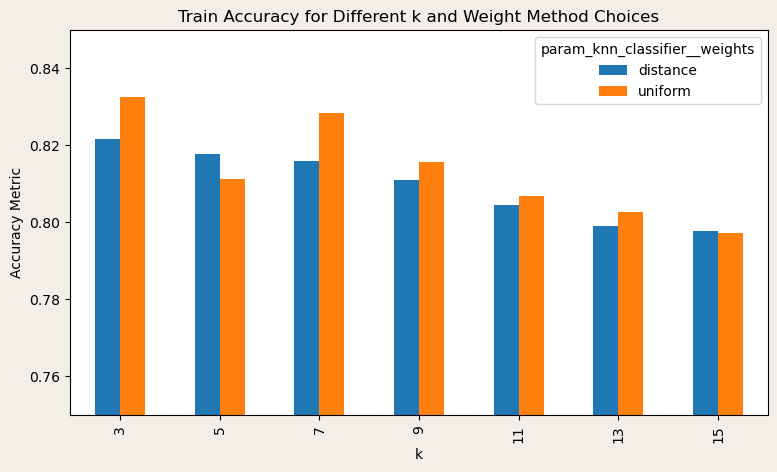

In [258]:
# Access the grid search results
results = grid_search_knn.cv_results_

# Extract k values, weights values and accuracy scores
df = pd.DataFrame(results)
df = df[df["param_knn_classifier__metric"] == "manhattan"]
grouped = df.groupby(["param_knn_classifier__n_neighbors", "param_knn_classifier__weights"])["mean_test_score"].mean().unstack()

# Plot the grouped bar chart
fig, ax = plt.subplots(figsize=(6, 4), gridspec_kw={'hspace': 0.8}, facecolor="#F3EEE7")
grouped.plot(kind='bar', figsize=(9, 5), ax=ax)

# Add plot details
ax.set_ylim(0.75, 0.85)
ax.set_xlabel('k')
ax.set_ylabel('Accuracy Metric')
ax.set_title('Train Accuracy for Different k and Weight Method Choices')
plt.show()


Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98        66
           1       0.85      0.92      0.88        24
           2       0.95      0.87      0.91        23

    accuracy                           0.95       113
   macro avg       0.93      0.92      0.92       113
weighted avg       0.95      0.95      0.95       113



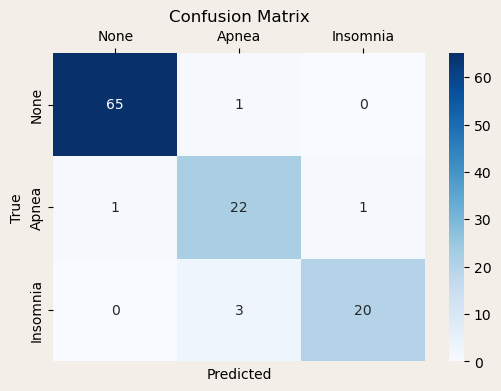

In [259]:
#get best pipeline
pipeline_knn = grid_search_knn.best_estimator_

# Generate prediction and show classification report
y_pred = pipeline_knn.predict(X_test)
class_report = classification_report(y_test, y_pred)
print("\nClassification Report:\n", class_report)

# Generate confusion matrix
class_labels = ["None","Apnea","Insomnia"]
conf_matrix = confusion_matrix(y_test, y_pred)

settings.plot_conf_matrix(class_labels, conf_matrix)

In [260]:
# Save baseline pipeline to file  
settings.save_pipeline("best_knn_classification_pipeline.pkl", pipeline_knn)

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left; max-width: 1050px; margin: 0 auto; color: #444444;">

<h3 align="left"><font color='#DEB887'>💡 Insights:</font></h3>

<ul>
    <li>Hypertuning shows Manhatten to be the best distance metric for the task, requiring 3 neighbours to optimise. No distance weighting improves the score in almost all values of k tested.</li>
    <li>Improvement in cross validated and test F1 score for the positive classes. Still big jump up to test score which is concerning. Repeated over my folds, test score is not as high as this. </li>
    <li>One less Insomnia sample misclassified as Apnea, and the same for vise versa. This is a positive development.</li> 
</ul>
</div>


*Addressing Class Imbalance: Exploring SMOTE-NC*

In [213]:
# instantiate SMOTENC object with categorical indicies of transformed X_train dataset
categorical_features = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
smote_nc = SMOTENC(categorical_features=categorical_features, random_state=42)

# Proving smote object works using the X array transformed by column_trans
from collections import Counter
smote_x, smote_y = smote_nc.fit_resample(transformed_X_train_array, y_train)
print(f"Original class counts: {Counter(y_train)}")
print(f"New class counts: {Counter(smote_y)}")

Original class counts: Counter({0: 153, 2: 54, 1: 54})
New class counts: Counter({2: 153, 1: 153, 0: 153})


In [214]:
# SET UP AND VERIFICATION OF TRANSFORMERS STEPS BEFORE PIPELINE

# Create a column transformer for ohe and scaling
column_trans = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'), X_train.select_dtypes(include=['object']).columns),
        ('scale', StandardScaler(), X_train.select_dtypes(include=['float64', 'int64']).columns)
    ],
    remainder='passthrough')

transformed_X_train_array = column_trans.fit_transform(X_train)
transformed_X_test_array = column_trans.transform(X_test)

# Convert to df as a sense check. Use only for interpretibility before using for pipeline. 
transformed_X_train_df = settings.convert_transformed_features_to_df(column_trans, transformed_X_train_array)
transformed_X_test_df = settings.convert_transformed_features_to_df(column_trans, transformed_X_test_array)

# # Check ohe and scaled datasets
# display("train: check for dummy encoded columns and scaled values (mean 0 and std 1)",transformed_X_train_df.shape, transformed_X_train_df.describe().loc[["mean", "std"],:])
# display("test: check for same dummy encoded columns and scaled values (mean close to 0 and std close to 1)",transformed_X_test_df.shape, transformed_X_test_df.describe().loc[["mean", "std"],:])

In [215]:
# Set up pipeline using imblearn's Pipeline class (SMOTE not compatible with sklearn's Pipeline)
# Reuse model with tuned hyperparameters
steps = [('column_trans', column_trans), ('smote', smote_nc), ("knn_classifier", model_knn)]
pipeline_knn = Pipeline_imb(steps)

# run training cross validation on pipeline 
cv_scores = cross_val_score(pipeline_knn, X_train, y_train, scoring=custom_scorer, cv=cv_knn)

settings.cross_val_summary(pipeline_knn, cv_scores, X_train, y_train, X_test, y_test, scorer=base_scorer)


Train Score: 86.900 %
Mean CV Train Score: 80.7800 % ( +- 5.900 % )
Test Score: 88.400 %


In [216]:
# Define the parameter grid
param_grid_knn = {
    'knn_classifier__n_neighbors': [3, 5, 7, 9, 11, 13, 15], 
    'knn_classifier__weights': ['uniform', 'distance'], 
    'knn_classifier__metric': ['euclidean', 'manhattan'] 
}

# Create and fit GridSearchCV object on train data
grid_search_knn = GridSearchCV(pipeline_knn, param_grid=param_grid_knn, scoring=custom_scorer, cv=cv_knn, n_jobs=-1)
grid_search_knn.fit(X_train, y_train)

settings.hyperparam_tune_summary(grid_search_knn, X_train, y_train, X_test, y_test, scorer=base_scorer)

Best Parameters:


,knn_classifier__metric,knn_classifier__n_neighbors,knn_classifier__weights
0,manhattan,5,distance


---------------------
Using best parameters
---------------------
Train Score: 90.100 %
Mean CV Train Score: 82.000 % ( +- 6.800 % )
Test Score: 84.500 %


<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left; max-width: 1050px; margin: 0 auto; color: #444444;">

<h3 align="left"><font color='#DEB887'>💡 Insights:</font></h3>

<ul>
    <li>Hyperparameter tuning causes overfitting with the best train score yet. SMOTE shows no improvement on cross validated or test positive class F1 scores.</li>
</ul>
</div>


*Reducing dimensionality*

In [246]:
# Create a column transformer for ohe and scaling
column_trans = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'), X_train.select_dtypes(include=['object']).columns),
        ('scale', StandardScaler(), X_train.select_dtypes(include=['float64', 'int64']).columns)
    ],
    remainder='passthrough')

transformed_X_train_array = column_trans.fit_transform(X_train)
transformed_X_test_array = column_trans.transform(X_test)

# Create a PCA object
from sklearn.decomposition import PCA
pca = PCA(n_components = 5)

transformed_pca_X_train_array = pca.fit_transform(transformed_X_train_array)
transformed_pca_X_test_array = pca.transform(transformed_X_test_array)

In [247]:
# create model
model_knn = KNeighborsClassifier() # default n_neighbors=5, weights='uniform', algorithm='auto', leaf_size=30, p=2, metric='minkowski'

# create sklearn pipeline
pipeline_knn = settings.create_pipeline(["preprocess", column_trans], ["pca", pca], ["knn_classifier", model_knn])

# run training cross validation on pipeline 
cv_scores = cross_val_score(pipeline_knn, X_train, y_train, scoring=custom_scorer, cv=cv_knn)

settings.cross_val_summary(pipeline_knn, cv_scores, X_train, y_train, X_test, y_test, scorer=base_scorer)

Train Score: 84.400 %
Mean CV Train Score: 80.3700 % ( +- 6.200 % )
Test Score: 89.100 %


*Hyperparam Tuning*

In [248]:
# Define the parameter grid
param_grid_knn = {
    'pca__n_components' : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'knn_classifier__n_neighbors': [2,4,6,8,10], 
    'knn_classifier__weights': ['uniform', 'distance'], 
    'knn_classifier__metric': ['euclidean', 'manhattan'] 
}

# Create and fit GridSearchCV object on train data
grid_search_knn = GridSearchCV(pipeline_knn, param_grid=param_grid_knn, scoring=custom_scorer, cv=cv_knn, n_jobs=-1)
grid_search_knn.fit(X_train, y_train)

settings.hyperparam_tune_summary(grid_search_knn, X_train, y_train, X_test, y_test, scorer=base_scorer)

Best Parameters:


,knn_classifier__metric,knn_classifier__n_neighbors,knn_classifier__weights,pca__n_components
0,euclidean,6,uniform,7


---------------------
Using best parameters
---------------------
Train Score: 84.400 %
Mean CV Train Score: 83.100 % ( +- 6.700 % )
Test Score: 86.000 %


<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left; max-width: 1050px; margin: 0 auto; color: #444444;">

<h3 align="left"><font color='#DEB887'>💡 Insights:</font></h3>

<ul>
    <li>Varying different levels of dimension reduction revealed no value for n_components that resulted in higher CV F1 score, and no improvement in test F1 score for the best params.</li>
</ul>
</div>
